# 🪐 Exoplanet Classification Pipeline
This notebook builds a complete ML pipeline for classifying exoplanet candidates using data from NASA’s KOI, TOI, and K2 missions.

We adressed almost all the research gaps in the research papers in Nasa Sources (https://academic.oup.com/mnras/article/513/4/5505/6472249, https://www.mdpi.com/2079-9292/13/19/3950)

Some of the gaps were:
- High class imbalance
- Lack of Broad Applicability/Robustness for Production
- Global Classifier Development
- Scarcity of Ensemble Algorithm Research
- Testing with Other Datasets (one of the research paper works only on KOI)
- Interpretability of Ensemble Algorithms (reproducibility and understanding of the algorithms' decision-making process)
- Computational Efficiency

and all of these solved in our pipeline

# The pipeline includes:
- Unified feature mapping across missions
- Feature engineering and scaling
- Model stacking (RF, XGBoost, LightGBM)
- Evaluation metrics (Accuracy, ROC-AUC)
- SHAP Explainability

Our goal is to build an intelligent, mission-agnostic, generalized, and robust pipeline that remains reliable and competitive across current and future NASA missions

**Accuracy is not a target — Robustness and Generalization is.**

# 📦 Imports

In [1]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import (accuracy_score, classification_report, roc_auc_score)
import logging
import lightgbm as lgb
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 📋 Logging config

In [2]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s"
)
logger = logging.getLogger("exo_model_pipeline")

# 📥 Data Loading

In [3]:
def read_with_fallback(path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(path, sep=",", comment="#", low_memory=False)
    except Exception:
        df = pd.read_csv(path, sep="\t", comment="#", low_memory=False)
    if df.shape[1] == 1:
        df = pd.read_csv(path, sep="\t", comment="#", low_memory=False)
    logger.info("Loaded %s with shape %s", path, df.shape)
    return df

# 🗺 Column Mapping

- We observed that the features among the three datasets are different, our approach was to find the common features across all the three datasets for better generalization and scalability. This unified feature set is generalized for upcoming missions like PLATO (2026) and Ariel (2029), which will require robust, scalable models.

- After careful observation we observe that there are some features (10 features) that are common but each mission (KOI, TOI, K2) uses different column names, for the same physical features. so we choose geniric names for the new columns and this mapping standardizes them

In [4]:
mapping = {
    "orbital_period_days": {"KOI": "koi_period", "TOI": "pl_orbper", "K2": "pl_orbper"},
    "planet_radius_rearth": {"KOI": "koi_prad", "TOI": "pl_rade", "K2": "pl_rade"},
    "insolation_flux_eflux": {"KOI": "koi_insol", "TOI": "pl_insol", "K2": "pl_insol"},
    "equilibrium_temp_K": {"KOI": "koi_teq", "TOI": "pl_eqt", "K2": "pl_eqt"},
    "stellar_teff_K": {"KOI": "koi_steff", "TOI": "st_teff", "K2": "st_teff"},
    "stellar_logg_cgs": {"KOI": "koi_slogg", "TOI": "st_logg", "K2": "st_logg"},
    "stellar_radius_rsun": {"KOI": "koi_srad", "TOI": "st_rad", "K2": "st_rad"},
    "stellar_mag": {"KOI": "koi_kepmag", "TOI": "st_tmag", "K2": "sy_vmag"},
    "ra_deg": {"KOI": "ra", "TOI": "ra", "K2": "ra"},
    "dec_deg": {"KOI": "dec", "TOI": "dec", "K2": "dec"},
}

In [5]:
def apply_mapping(df, source, mapping):
    """We Renamed dataset columns based on the mission source."""
    rename_dict = {m[source]: k for k, m in mapping.items() if m.get(source)}
    df = df.rename(columns=rename_dict)
    df["source"] = source
    return df

# ⚙ Feature Engineering

This function performs domain-inspired feature engineering:
- Log transforms for skewed astronomical quantities
- Ratios between planet and star properties

In [6]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Log transforms (safe: avoid negatives/zeros)
    for col in ["orbital_period_days", "planet_radius_rearth",
                "insolation_flux_eflux", "equilibrium_temp_K"]:
        if col in df.columns:
            df[f"log_{col}"] = np.log1p(df[col].clip(lower=0))
    # Derived ratios: planet-to-star size and temperature
    if {"planet_radius_rearth", "stellar_radius_rsun"}.issubset(df.columns):
        df["radius_ratio"] = df["planet_radius_rearth"] / (df["stellar_radius_rsun"] + 1e-6)
    if {"equilibrium_temp_K", "stellar_teff_K"}.issubset(df.columns):
        df["temp_ratio"] = df["equilibrium_temp_K"] / (df["stellar_teff_K"] + 1e-6)
    return df

# ⚙ PIPELINE CONSTRUCTION

In [7]:
def build_pipeline(n_jobs: int = -1) -> Pipeline:
    # Numeric preprocessing: median imputation + standard scaling
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    # Categorical preprocessing: most frequent imputation + one-hot encoding

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ]
    )

    # Base learners (diverse ensemble), Tuned estimators with class balancing
    # class_weight="balanced" is used to mitigate class imbalance which is (a known challenge in exoplanet data)
    estimators = [
        ("rf", RandomForestClassifier(
            n_estimators=400, max_depth=15,
            class_weight="balanced", random_state=42)),
        ("xgb", XGBClassifier(
            n_estimators=500, max_depth=7,
            learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
            scale_pos_weight=1, eval_metric="mlogloss",
            use_label_encoder=False, random_state=42)),
        ("lgbm", lgb.LGBMClassifier(
            n_estimators=500, max_depth=-1, num_leaves=64,
            subsample=0.8, colsample_bytree=0.8,
            class_weight="balanced", random_state=42))
    ]
    # Meta-learner (final estimator)
    stacking_clf = StackingClassifier(
        estimators=estimators,
        final_estimator=lgb.LGBMClassifier(
            n_estimators=200, learning_rate=0.05,
            num_leaves=32, class_weight="balanced",
            random_state=42
        ),
        cv=5,
        n_jobs=n_jobs
    )

    return Pipeline(steps=[("preprocessor", preprocessor),
                           ("clf", stacking_clf)])

# 🚀 Load & Prepare Data

In [8]:
koi = read_with_fallback("/content/cumulative_2025.09.24_03.42.53.csv")
toi = read_with_fallback("/content/TOI_2025.09.24_03.43.03.csv")
k2  = read_with_fallback("/content/k2pandc_2025.09.24_03.43.09.csv")

# Label mapping

For the Label mapping we observed that there is also different classes among the 3 datasets but there is 3 common classes with different names and these 3 are the most important so we Harmonize the different disposition labels across missions into "CONFIRMED", "CANDIDATE", and "FALSE POSITIVE"

In [9]:
koi_map = {"CONFIRMED": "CONFIRMED", "CANDIDATE": "CANDIDATE", "FALSE POSITIVE": "FALSE POSITIVE"}
toi_map = {"PC": "CANDIDATE", "CP": "CONFIRMED", "KP": "CONFIRMED", "FP": "FALSE POSITIVE"}
k2_map  = {"CONFIRMED": "CONFIRMED", "CANDIDATE": "CANDIDATE", "FALSE POSITIVE": "FALSE POSITIVE"}

In [10]:
koi["label"] = koi["koi_disposition"].map(koi_map)
toi["label"] = toi["tfopwg_disp"].map(toi_map)
k2["label"]  = k2["disposition"].map(k2_map)

In [11]:
koi = koi.dropna(subset=["label"])
toi = toi.dropna(subset=["label"])
k2  = k2.dropna(subset=["label"])

# Apply mapping + concat

In [12]:
koi_mapped = apply_mapping(koi, "KOI", mapping)
toi_mapped = apply_mapping(toi, "TOI", mapping)
k2_mapped  = apply_mapping(k2,  "K2", mapping)

In [13]:
df = pd.concat([koi_mapped, toi_mapped, k2_mapped], ignore_index=True)
df = df.dropna(axis=1, how="all")

In [14]:
# Only keep strict mapped features + source
features = list(mapping.keys()) + ["source"]
df = df[features + ["label"]]

In [15]:
# Add engineered features
df = add_features(df)

In [16]:
df.to_csv("combined_exoplanet_data.csv", index=False)
from google.colab import files
files.download("combined_exoplanet_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
X = df.drop(columns=["label"])
y = df["label"]

In [18]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# 📊 Train + Evaluate

In [19]:
pipeline = build_pipeline()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [20]:
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 16516, number of used features: 9
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['orbital_period_days',
                                                   'planet_radius_rearth',
                                                   'insolation_flux_eflux',
                                                   'equilibrium_temp_K',
                                                   'stellar_teff_K',
                                                   'stellar_logg_cgs',
                                                   'stellar_radius_rsun',
                                                   'stellar_mag', 'ra_deg',
                                                   'dec_deg',
                                                   'log_o...
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=500,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)),
                                                ('lgbm',
                                                 LGBMClassifier(class_weight='balanced',
                                                                colsample_bytree=0.8,
                                                                n_estimators=500,
                                                                num_leaves=64,
                                                                random_state=42,
                                                                subsample=0.8))],
                                    final_estimator=LGBMClassifier(class_weight='balanced',
                                                                   learning_rate=0.05,
                                                                   n_estimators=200,
                                                                   num_leaves=32,
                                                                   random_state=42),
                                    n_jobs=-1))])

In [21]:
y_pred = pipeline.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [22]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC (macro):", roc_auc_score(
    y_test, pipeline.predict_proba(X_test), multi_class="ovr", average="macro"
))

Accuracy: 0.7757326229111164
                precision    recall  f1-score   support

     CANDIDATE       0.79      0.70      0.74      1605
     CONFIRMED       0.77      0.85      0.81      1259
FALSE POSITIVE       0.76      0.79      0.78      1265

      accuracy                           0.78      4129
     macro avg       0.78      0.78      0.78      4129
  weighted avg       0.78      0.78      0.77      4129



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


ROC-AUC (macro): 0.9155698727266813


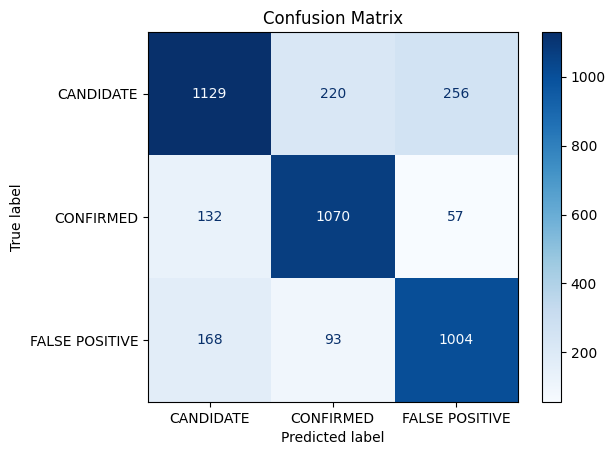

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [24]:
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
class_names = pipeline.classes_
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("Confusion Matrix:")
display(cm_df)

Confusion Matrix:


,CANDIDATE,CONFIRMED,FALSE POSITIVE
CANDIDATE,1129,220,256
CONFIRMED,132,1070,57
FALSE POSITIVE,168,93,1004


Compared to the literature we achieved competitive accuracy, precision, recall, f1-score and ROC-AUC with **Better Generalization**

# Weights and Metadata files

In [25]:
import pickle
model_filename = "exoplanet_pipeline.pkl"
with open(model_filename, "wb") as f:
    pickle.dump(pipeline, f)

print(f"Model saved to {model_filename}")

Model saved to exoplanet_pipeline.pkl


In [26]:
def save_artifacts(model, model_path, metadata, metadata_path):
    """Saves the trained model and metadata using pickle."""
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    with open(metadata_path, 'wb') as f:
        pickle.dump(metadata, f)
    print(f"Artifacts saved: model to {model_path}, metadata to {metadata_path}")

def load_artifacts(model_path, metadata_path):
    """Loads the trained model and metadata using pickle."""
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    with open(metadata_path, 'rb') as f:
        metadata = pickle.load(f)
    print(f"Artifacts loaded: model from {model_path}, metadata from {metadata_path}")
    return model, metadata

In [27]:
feature_cols = X.columns.tolist()

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "roc_auc_macro": roc_auc_score(y_test, pipeline.predict_proba(X_test), multi_class="ovr", average="macro"),
    "classification_report": classification_report(y_test, y_pred, output_dict=True)
}

categories = sorted(y.unique())

metadata = {"feature_cols": feature_cols,
            "baseline_stats": "Placeholder for baseline statistics",
            "metrics": metrics,
            "categories": categories}

save_artifacts(pipeline, "./exo_model.pkl", metadata, "./exo_meta.pkl")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Artifacts saved: model to ./exo_model.pkl, metadata to ./exo_meta.pkl


# Inference

In [28]:
# Get a single sample from the test set
sample = X_test.iloc[[0]]

# Make a prediction
prediction = pipeline.predict(sample)

print("Sample features:")
display(sample)
print("\nPrediction:", prediction[0])

Sample features:


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,orbital_period_days,planet_radius_rearth,insolation_flux_eflux,equilibrium_temp_K,stellar_teff_K,stellar_logg_cgs,stellar_radius_rsun,stellar_mag,ra_deg,dec_deg,source,log_orbital_period_days,log_planet_radius_rearth,log_insolation_flux_eflux,log_equilibrium_temp_K,radius_ratio,temp_ratio
8942,1.81708,1.39,1056.39,1454.0,5808.0,4.503,0.963,15.591,282.55869,48.63097,KOI,1.035701,0.871293,6.963559,7.282761,1.443405,0.250344



Prediction: CONFIRMED


# 🔎 SHAP Explainability

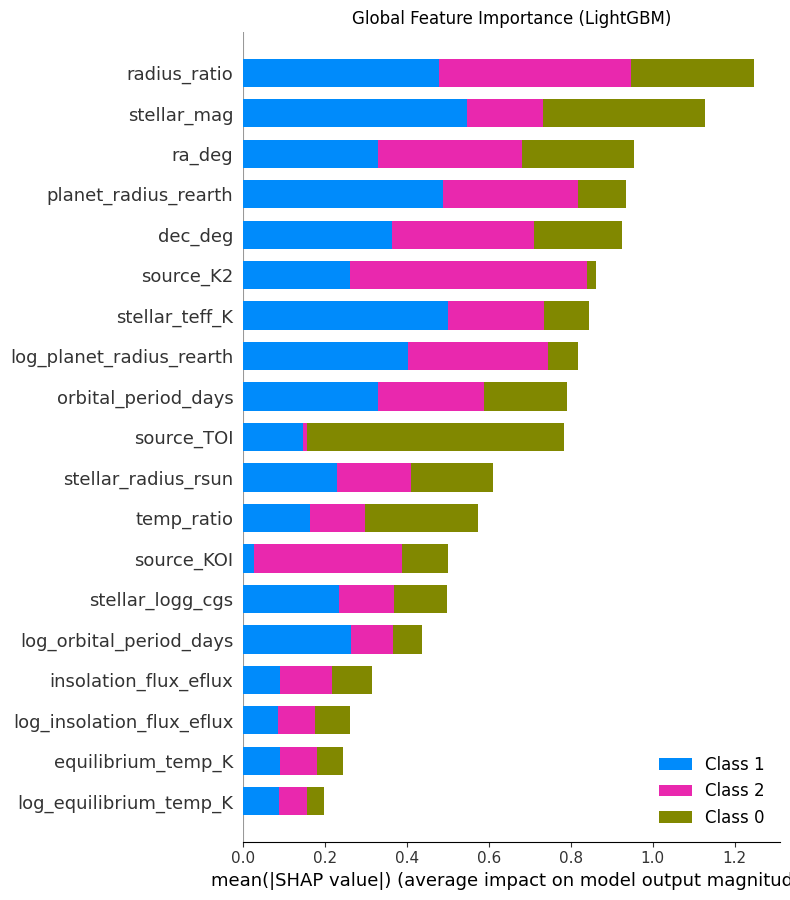

In [29]:
# Extract stacking classifier from the pipeline
stacking_clf = pipeline.named_steps["clf"]

# Extract best-performing base model (LightGBM)
best_model = stacking_clf.named_estimators_["lgbm"]

# Extract the preprocessor and transform test data
preprocessor = pipeline.named_steps["preprocessor"]
X_test_processed = preprocessor.transform(X_test)

# Get feature names after preprocessing
feature_names = []
for name, transformer, features in preprocessor.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        feature_names.extend(transformer.get_feature_names_out(features))
    else:
        feature_names.extend(features)  # fallback

# Convert to DataFrame for SHAP visualization
X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

# =========================
# Build SHAP Explainer
# =========================
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_processed)

# =========================
# GLOBAL SHAP (Feature Importance)
# =========================
plt.title("Global Feature Importance (LightGBM)")
if isinstance(shap_values, list):
    shap.summary_plot(np.abs(np.array(shap_values)).mean(axis=0), X_test_processed, plot_type="bar")
else:
    shap.summary_plot(shap_values, X_test_processed, plot_type="bar")
plt.show()

`PathFinders`